### 1. Importar librerías

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

### 2. Cargar datos

In [27]:
df = pd.read_csv('data_monitoreo_contaminantes_filtrado.csv')
df['FECHA'] = pd.to_datetime(df['FECHA'])

### 3. Preparación

In [28]:
# Ingeniería de características
df['DIA_SEMANA'] = df['FECHA'].dt.dayofweek
df['MES'] = df['FECHA'].dt.month
df['AÑO'] = df['FECHA'].dt.year
df['ES_FIN_DE_SEMANA'] = df['DIA_SEMANA'].isin([5, 6]).astype(int)

# Agregación de datos
df_agregado = df.groupby(['ESTACION', 'DISTRITO', 'AÑO', 'MES', 'DIA_SEMANA', 'ES_FIN_DE_SEMANA', 'HORA'])['PM10'].mean().reset_index()

# Selección de características
features = ['ESTACION', 'DISTRITO', 'HORA', 'DIA_SEMANA', 'MES', 'AÑO', 'ES_FIN_DE_SEMANA']
X = df_agregado[features]
y = df_agregado['PM10']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Preprocesamiento

In [29]:
# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ESTACION', 'DISTRITO']),
        ('num', StandardScaler(), ['HORA', 'DIA_SEMANA', 'MES', 'AÑO', 'ES_FIN_DE_SEMANA'])
    ])

### 5. Modelo Híbrido (Random Forest + Gradient Boosting)

In [36]:
# Modelos base
rf_model = RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_split=4, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Modelo híbrido usando Stacking
stacking_model = StackingRegressor(
    estimators=[('rf', rf_model), ('gb', gb_model)],
    final_estimator=RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),  # Meta-modelo
    n_jobs=-1
)

In [37]:
# Crear pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', stacking_model)
])

# Entrenar modelo híbrido
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

# Métricas de rendimiento
print("\nMétricas para Modelo Híbrido (Random Forest + Gradient Boosting):")
print(f"Error Cuadrático Medio: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Error Absoluto Medio: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


Métricas para Modelo Híbrido (Random Forest + Gradient Boosting):
Error Cuadrático Medio: 72.59
Error Absoluto Medio: 4.86
R² Score: 0.92


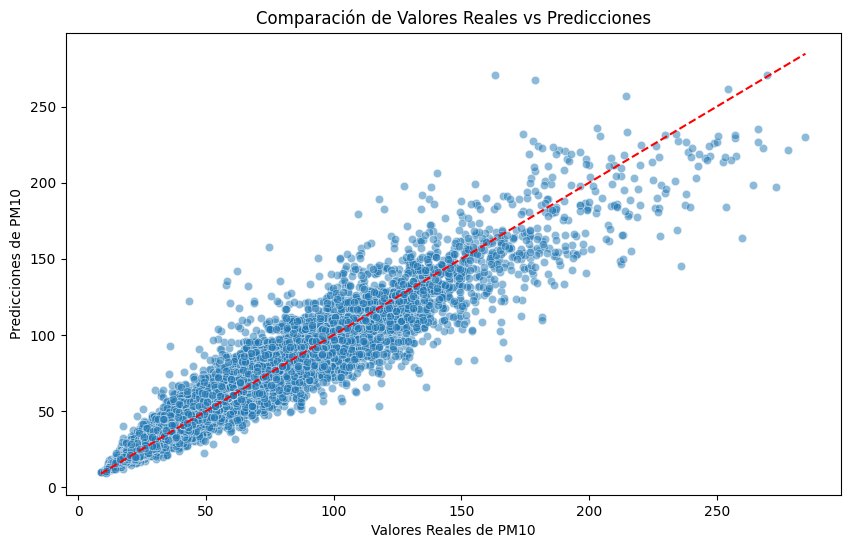

In [40]:
# Visualización de error con Gráfica de Dispersión
errores = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales de PM10")
plt.ylabel("Predicciones de PM10")
plt.title("Comparación de Valores Reales vs Predicciones")
plt.show()

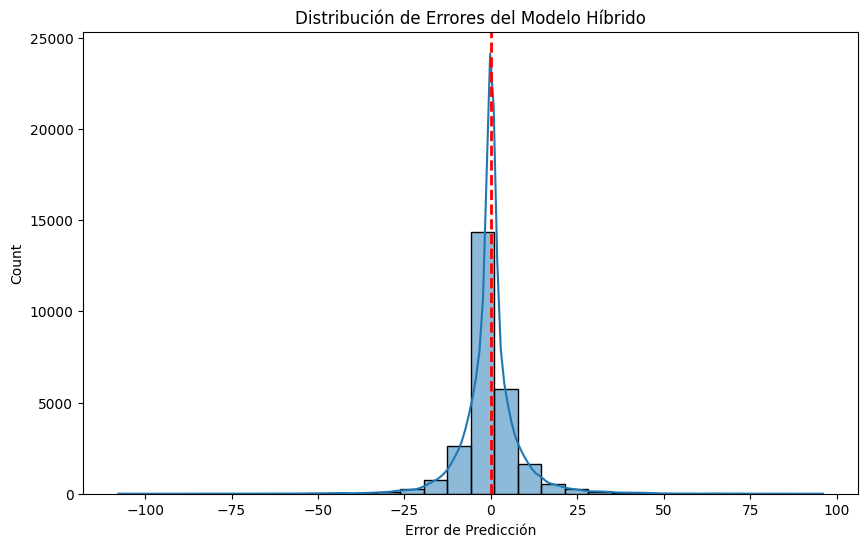

In [41]:
# Histograma del error
plt.figure(figsize=(10, 6))
sns.histplot(errores, bins=30, kde=True)
plt.axvline(errores.mean(), color='red', linestyle='dashed', linewidth=2)
plt.title("Distribución de Errores del Modelo Híbrido")
plt.xlabel("Error de Predicción")
plt.show()

### 6. Guardar el Modelo Entrenado

In [43]:
# Guardar el modelo entrenado
joblib.dump(pipeline, "modelo/modelo_hibrido_rf_gb.pkl")

print("✅ Modelo guardado exitosamente como 'modelo_hibrido_rf_gb.pkl'")

✅ Modelo guardado exitosamente como 'modelo_hibrido_rf_gb.pkl'
